# TR-RB simulation

Luca Mechelli, Tim Keil

# Preparations

## details

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [2]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

## problem definition

In [3]:
from pymor.discretizers.builtin.cg import InterpolationOperator

grid, bi = load_gmsh('../../../fin_data/fin_mesh.msh')

from pdeopt.problems import Fin_problem

problem = Fin_problem(6)
mu_d = problem.parameter_space.sample_randomly(1, seed=222)[0] # 222
mu_d['biot'] = np.array(0.01)
# mu_for_u_d['k2'] = np.array(10)
mu_d['k0'] = np.array(0.1)
#mu_d['k3'] = np.array(0.1)
#mu_for_u_d['k4'] = np.array(0.1)
print('mu desired:', mu_d)

from pdeopt.discretizer import discretize_fin_pdeopt_stationary_cg

opt_fom, data, mu_bar = discretize_fin_pdeopt_stationary_cg(problem, grid, bi, mu_d, 
                                                            product='fixed_energy',
                                                            add_constant_term=True)

mu desired: {biot: 0.01, k0: 0.1, k1: 8.37317446377103, k2: 6.572276066240383, k3: 0.46651735398635275, k4: 1.8835410659596712}
I am using the corrected functional!!
I am using the OLD gradient!!
{biot: 0.1, k0: 1.0, k1: 1.0, k2: 1.0, k3: 1.0, k4: 1.0}
my product is fixed_energy


In [4]:
print('information on the grid:')
print(data['grid'])

radius = 0.1               # TR radius 
FOC_tolerance = 5e-4       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 40                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)

information on the grid:
UnstructuredTriangleGrid with 151072 triangles, 228608 edges, 77537 vertices


Now we pick one specific starting parameter

In [5]:
# starting with
mu = problem.parameter_space.sample_randomly(1, seed= 7822)[0]
print(mu)

{biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}


## Visualizations

Visualize the position of left- and right-hand sides parameters

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f866c7ffdd0>

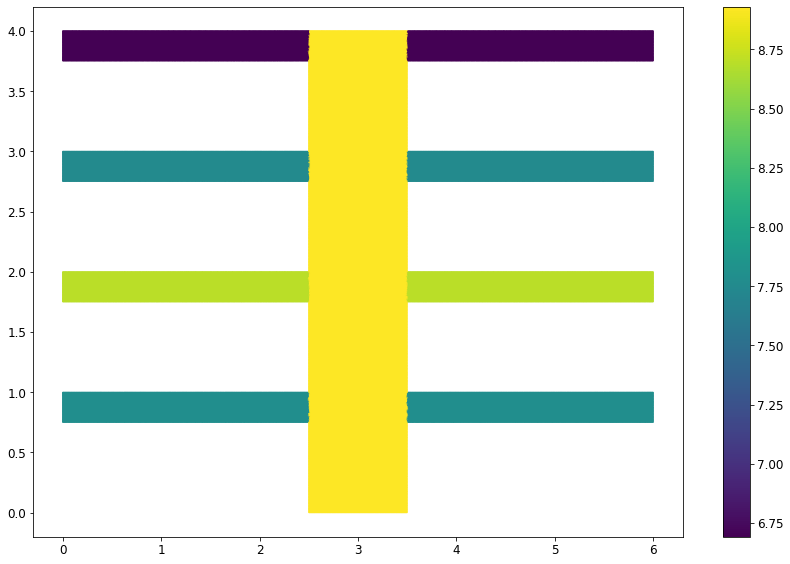

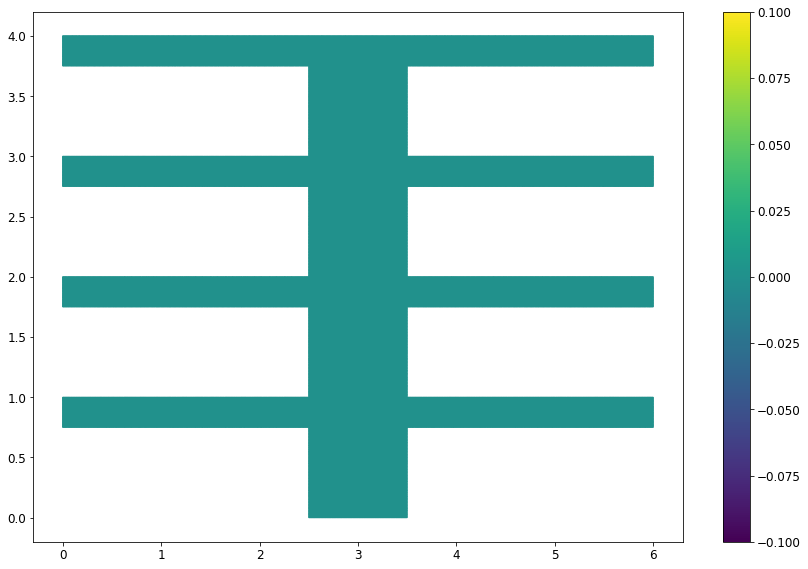

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
opt_fom.visualize(diff)
opt_fom.visualize(rhs)

We can easily solve the primal and dual equations by calling 

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f8660a4de50>

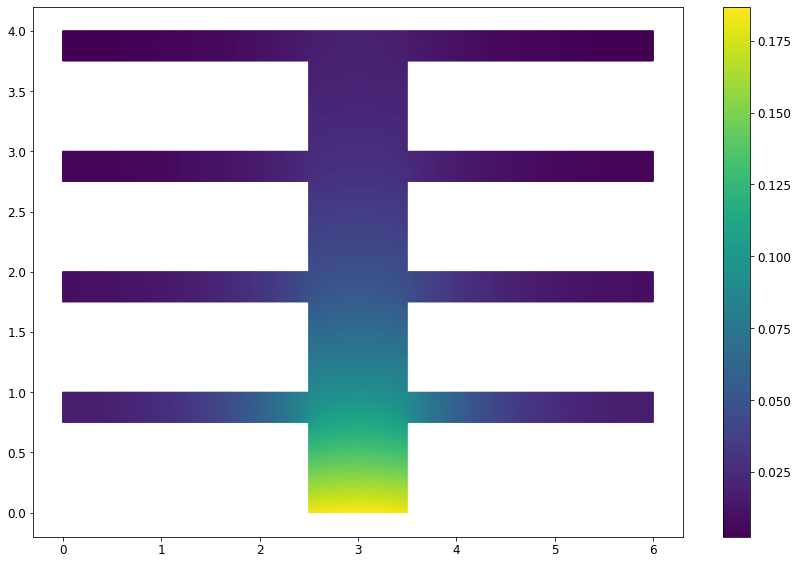

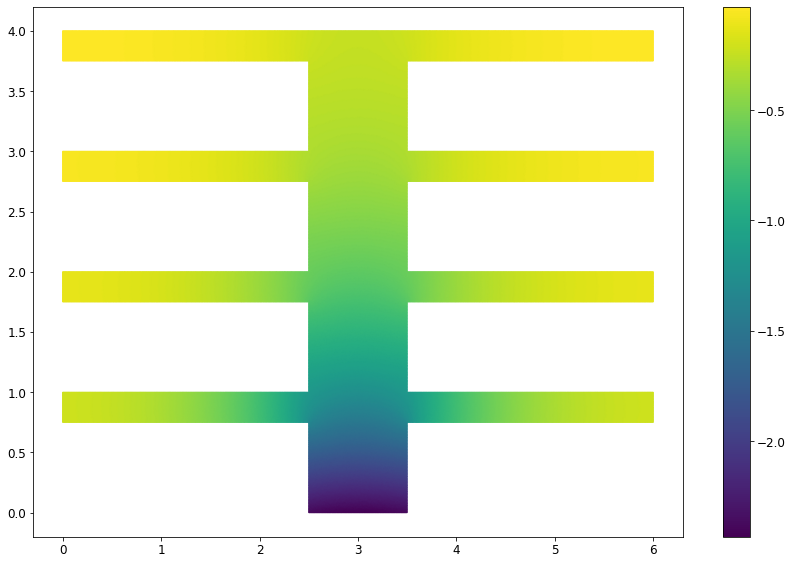

In [7]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)
opt_fom.visualize(p)

# Full Order Optimization

In [8]:
mu_opt = mu_d

mu_opt_as_array = opt_fom.parse_parameter_inverse(mu_opt)
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', opt_fom.parse_parameter_inverse(mu))
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [0.01       0.1        8.37317446 6.57227607 0.46651735 1.88354107]
Optimal J:  1.0

Starting parameter:  [0.83104703 8.93021925 7.78496907 8.69671132 7.75788935 6.69144447]
Starting J:  7480.537583730829


## FOM BFGS

In [9]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors, compute_actual_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True }


muoptfom,_,_,_, times_2, mus_2, Js_2, FOC_2 = solve_optimization_subproblem_BFGS(opt_fom,opt_fom.parameter_space,mu,TR_parameters, timing=True)
times_full_2, J_error_2, mu_error_2 = compute_errors(opt_fom, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_2, Js_2, times_2, 0)

Starting parameter {biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}
Step [0.01       0.1        7.76886221 8.64181952 0.1        5.33538087], functional 3.0404951235126703 , FOC condition 3.3824215371370427
Step [0.01009446 0.10001968 7.76886223 8.64181899 0.10001289 5.3353692 ], functional 3.0401665710617465 , FOC condition 1.9432477460955917
Step [0.01       0.10051682 7.76886329 8.6418217  0.10047979 5.33543882], functional 3.039477589344912 , FOC condition 1.9406232894688826
Step [0.01       0.1        7.77182706 8.63038869 0.84842582 5.11204039], functional 2.8557105126538005 , FOC condition 1.1792458066981448
Step [0.01       0.1        7.7807262  8.57650406 0.50512719 4.04360242], functional 1.710010914276836 , FOC condition 0.6359290688550276
Step [0.01       0.1        7.80109539 8.46004762 0.3762194  2.29227253], functional 1.0858725822881183 , FOC condition 1.153175468608852
Step [0

Step [0.01009526 0.1        7.83336839 8.28898297 0.45289471 2.02701335], functional 1.0402865222311561 , FOC condition 0.08395859106382732
Step [0.01       0.1        7.83333333 8.28920715 0.4521311  2.03532037], functional 1.039925091127273 , FOC condition 0.8153670861996392
Step [0.01000605 0.10000128 7.83333348 8.28920639 0.45213126 2.0353191 ], functional 1.0399237128852974 , FOC condition 0.08851919453101367
Step [0.01005148 0.1        7.8339275  8.28609181 0.45277564 2.0301388 ], functional 1.0397436795180113 , FOC condition 0.08515622342880923
Step [0.01       0.1        7.83624462 8.27412891 0.45207239 2.0447008 ], functional 1.0397236137386443 , FOC condition 0.8110702609167885
Step [0.01000602 0.10000127 7.83624479 8.27412807 0.45207255 2.04469957], functional 1.0397222451861268 , FOC condition 0.08986853613229609
Step [0.01005225 0.1        7.83690515 8.27067291 0.45270164 2.03968453], functional 1.0395308868209412 , FOC condition 0.0865664193304782
Step [0.01       0.1    

Step [0.01000595 0.10000126 7.89082567 7.9961411  0.44797544 2.10682133], functional 1.0329437705794504 , FOC condition 0.11112675917509773
Step [0.01007155 0.1        7.89277748 7.98615205 0.44862282 2.10142314], functional 1.0326341053846306 , FOC condition 0.1072777430503164
Step [0.01       0.1        7.8935947  7.98218018 0.44798523 2.10636209], functional 1.0324383506444406 , FOC condition 0.8032665732554851
Step [0.01000594 0.10000126 7.8935952  7.98217765 0.44798539 2.10636075], functional 1.032436932544229 , FOC condition 0.11092027530350743
Step [0.01007249 0.1        7.89561523 7.97184745 0.44863846 2.10089562], functional 1.0321272235452312 , FOC condition 0.10702565950563524
Step [0.01       0.1        7.89644045 7.9678548  0.44795415 2.1061788 ], functional 1.0319448640655366 , FOC condition 0.8015293464151045
Step [0.01000593 0.10000125 7.89644096 7.96785219 0.44795431 2.10617744], functional 1.0319434483612184 , FOC condition 0.11090117822981062
Step [0.01007352 0.1    

Step [0.01       0.1        7.94392821 7.73055625 0.44731042 2.10113437], functional 1.0243657772903418 , FOC condition 0.7782913652822268
Step [0.01000575 0.10000122 7.94392894 7.73055254 0.44731062 2.10113262], functional 1.0243643907751618 , FOC condition 0.11091573617559296
Step [0.01009719 0.1        7.94691704 7.71540158 0.44814097 2.09397585], functional 1.0242426252935388 , FOC condition 0.10575642651099003
Step [0.01       0.1        7.94606333 7.72001487 0.44713436 2.10196617], functional 1.024138080495689 , FOC condition 0.7791984124049158
Step [0.01000576 0.10000122 7.94606407 7.72001111 0.44713457 2.10196438], functional 1.0241366880264167 , FOC condition 0.11162929956787118
Step [0.01009906 0.1        7.94909294 7.70465556 0.44798151 2.09466668], functional 1.0240332304189934 , FOC condition 0.10636042040138188
Step [0.01       0.1        7.94809127 7.71002634 0.44692581 2.1030702 ], functional 1.0239483259872486 , FOC condition 0.7805736060204077
Step [0.01000577 0.10000

Step [0.01005884 0.1        8.03586987 7.29570375 0.43894815 2.13828553], functional 1.0180383872204999 , FOC condition 0.14601949459670618
Step [0.01       0.1        8.03678492 7.29234225 0.4386263  2.14046612], functional 1.0179010357728373 , FOC condition 0.839577346375711
Step [0.01000617 0.1000013  8.03678571 7.29233828 0.43862655 2.140464  ], functional 1.017899450598037 , FOC condition 0.14819497777050486
Step [0.01005835 0.1        8.03840549 7.28423669 0.4391315  2.13614411], functional 1.0176547233998718 , FOC condition 0.1449702439248413
Step [0.01       0.1        8.04048811 7.27643272 0.43851114 2.14026701], functional 1.0176214527521665 , FOC condition 0.8389931999537924
Step [0.01000616 0.1000013  8.04048889 7.27642879 0.43851139 2.14026488], functional 1.0176198713471507 , FOC condition 0.14858281934730622
Step [0.0100581  0.1        8.042088   7.26842309 0.4390192  2.13592998], functional 1.0173759506514273 , FOC condition 0.14534598604593074
Step [0.01       0.1     

Step [0.01000566 0.1000012  8.10526293 7.03183004 0.44009498 2.11225055], functional 1.0119328853612757 , FOC condition 0.13790266588234146
Step [0.01005142 0.1        8.1064706  7.02552391 0.44060041 2.10804816], functional 1.0117422288815305 , FOC condition 0.13475686640983386
Step [0.01       0.1        8.10865415 7.02132356 0.44024146 2.11047493], functional 1.0116788454875234 , FOC condition 0.765001646062933
Step [0.01000562 0.10000119 8.10865473 7.02132052 0.44024171 2.11047288], functional 1.0116775482887022 , FOC condition 0.1370552331932705
Step [0.01005077 0.1        8.10983466 7.01512564 0.44074437 2.10629842], functional 1.0114888083803635 , FOC condition 0.13393137987054013
Step [0.01       0.1        8.11464122 7.00526734 0.44016711 2.11000171], functional 1.01147130155654 , FOC condition 0.7583009022658601
Step [0.01000557 0.10000118 8.11464177 7.00526439 0.44016736 2.10999967], functional 1.011470027040474 , FOC condition 0.13726435372988752
Step [0.01009489 0.1       

Step [0.01       0.1        8.18300035 6.86816662 0.44263922 2.08255571], functional 1.0081642423748605 , FOC condition 0.616077384066354
Step [0.01000451 0.10000095 8.18300067 6.86816431 0.44263945 2.08255381], functional 1.0081633850135603 , FOC condition 0.12342614753080657
Step [0.01008302 0.1        8.184336   6.85875246 0.44358692 2.074832  ], functional 1.0081618697869317 , FOC condition 0.11764082506433801
Step [0.01       0.1        8.18389146 6.86746292 0.44263055 2.08257307], functional 1.0081589352530642 , FOC condition 0.6141294368282924
Step [0.01000449 0.10000095 8.18389179 6.8674606  0.44263079 2.08257117], functional 1.0081580817814313 , FOC condition 0.12346263664876354
Step [0.010044   0.1        8.18455952 6.86272201 0.44310706 2.0786894 ], functional 1.0080124250225708 , FOC condition 0.12054961938946573
Step [0.01       0.1        8.19154876 6.85857481 0.44281853 2.0805812 ], functional 1.0079470580413954 , FOC condition 0.5958262563863056
Step [0.01000435 0.10000

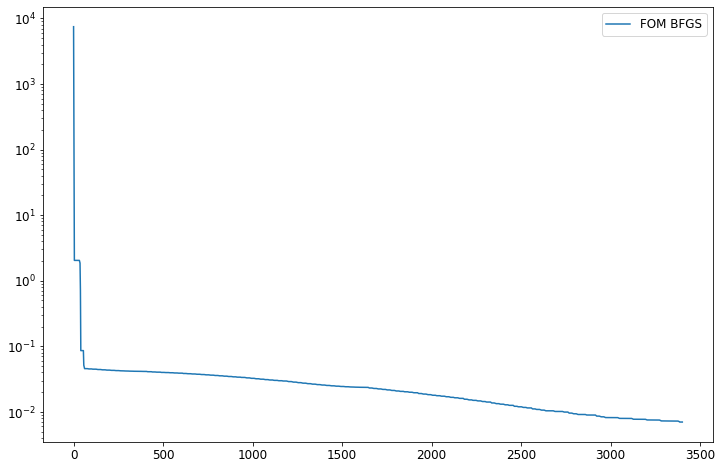

In [10]:
plt.semilogy(times_full_2,J_error_2, label='FOM BFGS')
plt.legend()

# TR approach

In [11]:
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor

from pymor.parameters.functionals import MinThetaParameterFunctional

ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

## BFGS (Lagrange-Basis)

#### NCD-Corrected Functional - Variant 3(a)

In [12]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=True)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar,
                                                            adjoint_estimate=True)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}

from pdeopt.TR import TR_algorithm

mus_23, times_23, Js_23, FOC_23 = TR_algorithm(opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_23_actual, J_error_23_actual, mu_error_23_actual, FOC_23_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_23[1:], Js_23, times_23, tictoc, FOC_23)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}
Starting value of the cost: 7480.537583730829
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 2 - Cost Functional: 1510.5919383793155 - mu: {biot: 0.01, k0: 5.258147702809897, k1: 7.78489864906287, k2: 8.69648153093483, k3: 7.618116632759615, k4: 6.685786253834742}
computing the fom gradient since the model was enriched
First order critical condition: 9.220166829845253
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method


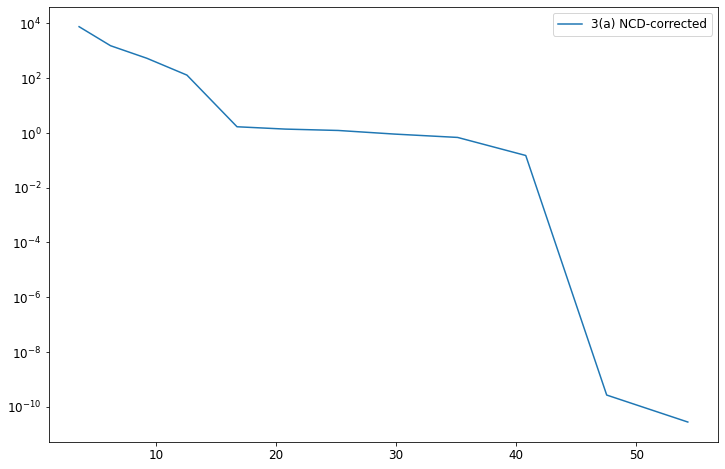

In [13]:
plt.semilogy(times_full_23_actual,J_error_23_actual, label='3(a) NCD-corrected')
plt.legend()

#### Standard approach - Variant 1(a)

In [14]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = { 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}
from pdeopt.TR import TR_algorithm
mus_25, times_25, Js_25, FOC_25 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_25_actual, J_error_25_actual, mu_error_25_actual, FOC_25_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_25[1:], Js_25, times_25, tictoc, FOC_25)


Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}
Starting value of the cost: 7480.537583730829
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 2 - Cost Functional: 1510.591938379347 - mu: {biot: 0.01, k0: 5.258147702809897, k1: 7.78489864906287, k2: 8.69648153093483, k3: 7.618116632759615, k4: 6.685786253834742}
computing the fom gradient since the model was enriched
First order critical condition: 9.220166829845253
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
b

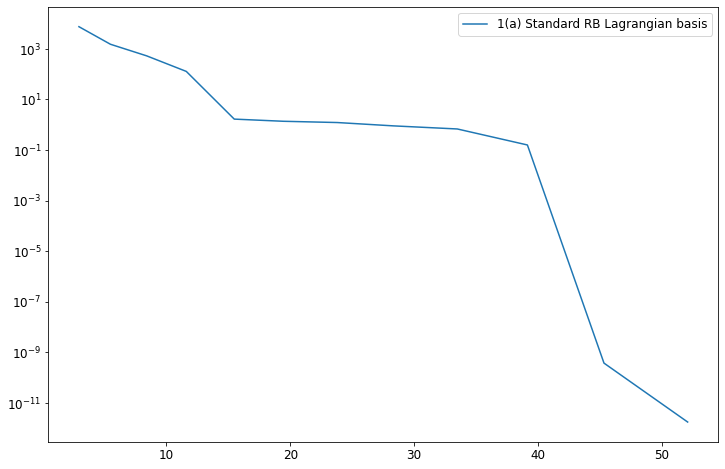

In [15]:
plt.semilogy(times_full_25_actual,J_error_25_actual, label='1(a) Standard RB Lagrangian basis')
plt.legend()

#### Qian et al. 2017 version

In [16]:
#Qian-Grepl
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product, 
                                                            coercivity_estimator=ce, mu_bar=mu_bar,
                                                            prepare_for_gradient_estimate= True)

opt_rom = pdeopt_reductor.reduce()
tictoc = time.time() - tic

TR_parameters = {'Qian-Grepl': True,
                 'beta': beta, 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i,  
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": False, 'timings': True}

mus_26, times_26,Js_26, FOC_26, opt_rom = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params, return_opt_rom=True)

times_full_26_actual, J_error_26_actual, FOC_26_actual, mu_error_26_actual = compute_actual_errors(
    opt_fom, J_start, J_opt, mus_26, times_26, tictoc, mu, mu_opt_as_array)

Starting with two bases. Primal and dual have length 1 and 1
GRAD J ESTIMATOR: non corrected estimator
QIAN et al. 2017 Method
starting parameter {biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}
Starting value of the cost: 7480.537583730829
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 2, 2, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 0 - j 2 - Cost Functional: 1510.591938379347 - mu: {biot: 0.01, k0: 5.258147702809897, k1: 7.78489864906287, k2: 8.69648153093483, k3: 7.618116632759615, k4: 6.685786253834742}
estimate_gradient 6.988373041526142e-09
First order critical condition: 9.220166829845478
******************************* 

___

Subproblem converged: FOC = 5.5456687501654344e-09, mu_diff = 1.3824225259471297e-07, J_diff = 4.263256414489596e-14 
relative differences mu 1.3824225259471297e-07 and J 4.263256414489596e-14
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 14, 14, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 12 - j 27 - Cost Functional: 1.0000000000166125 - mu: {biot: 0.01, k0: 0.1, k1: 8.373171920622681, k2: 6.572275713504115, k3: 0.46651731554778003, k4: 1.8835410484680617}
estimate_gradient 1.0838420817066613e-08
First order critical condition: 7.644365576916302e-06
******************************* 


Stopping criteria fulfilled: normgrad 7.644365576916302e-06 + estimate_gradient 1.0838420817066613e-08
computing actual errors .... 


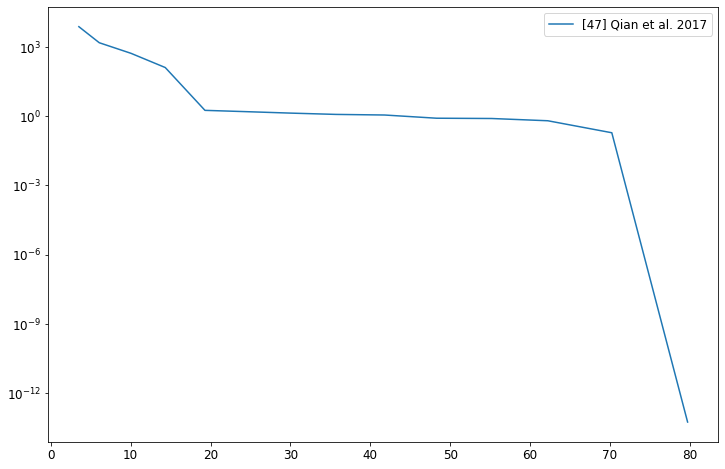

In [17]:
plt.semilogy(times_full_26_actual,J_error_26_actual, label='[47] Qian et al. 2017')
plt.legend()

#### semi NCD-corrected (Variant 2a)

In [18]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_39, times_39, Js_39, FOC_39 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_39_actual, J_error_39_actual, mu_error_39_actual, FOC_39_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_39[1:], Js_39, times_39, tictoc, FOC_39)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}
Starting value of the cost: 7480.537583730829
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 2 - Cost Functional: 1510.5919383793155 - mu: {biot: 0.01, k0: 5.258147702809897, k1: 7.78489864906287, k2: 8.69648153093483, k3: 7.618116632759615, k4: 6.685786253834742}
computing the fom gradient since the model was enriched
First order critical condition: 9.220166829845253
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method


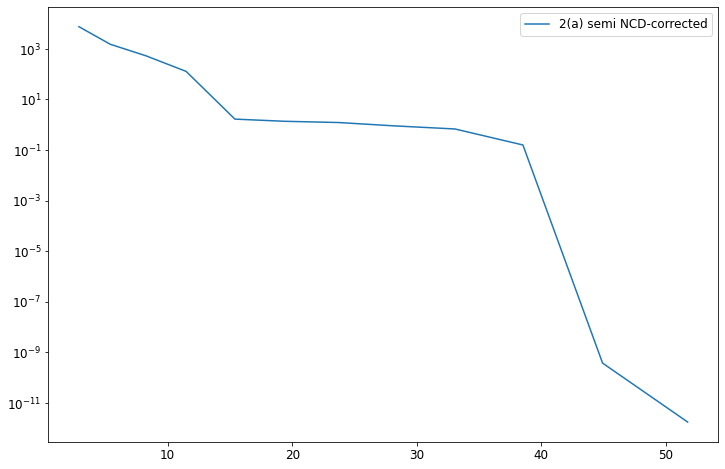

In [19]:
plt.semilogy(times_full_39_actual,J_error_39_actual, label='2(a) semi NCD-corrected')
plt.legend()

## TR BFGS - Single Basis - Variant 1(b)

In [20]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                        RBbasis, dual_RBbasis, 
                                                        opt_product=opt_fom.opt_product,
                                                        coercivity_estimator=ce,
                                                        unique_basis=True,
                                                        mu_bar=mu_bar,
                                                        true_lagrange=False)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic


TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_54, times_54, Js_54, FOC_54 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_54_actual, J_error_54_actual, mu_error_54_actual, FOC_54_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_54[1:], Js_54, times_54, tictoc, FOC_54)

Starting with only one basis with length 1
starting parameter {biot: 0.8310470302337475, k0: 8.930219246188496, k1: 7.784969072708997, k2: 8.696711315971228, k3: 7.7578893527924615, k4: 6.691444466389897}
Starting value of the cost: 7480.537583730829
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Length of Basis is 2
k: 0 - j 2 - Cost Functional: 1510.591938379307 - mu: {biot: 0.01, k0: 5.258147702809897, k1: 7.78489864906287, k2: 8.69648153093483, k3: 7.618116632759615, k4: 6.685786253834742}
computing the fom gradient since the model was enriched
First order critical condition: 9.220166829845253
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the su

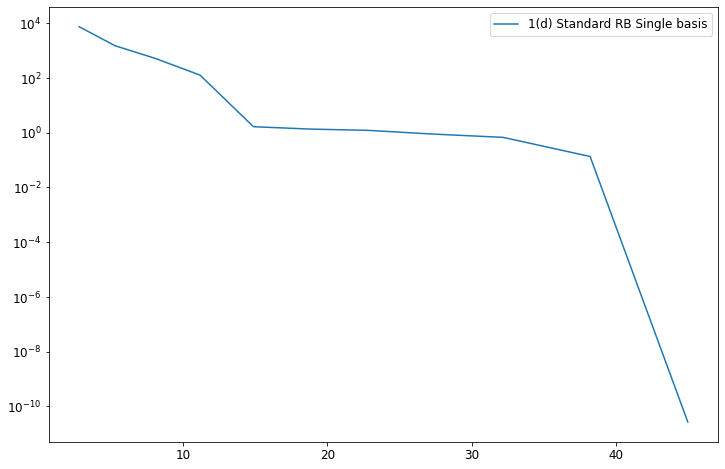

In [21]:
plt.semilogy(times_full_54_actual,J_error_54_actual, label='1(d) Standard RB Single basis')
plt.legend()

# Results

{biot: 0.01, k0: 0.1, k1: 8.37317446377103, k2: 6.572276066240383, k3: 0.46651735398635275, k4: 1.8835410659596712}


<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f865fdb8ad0>

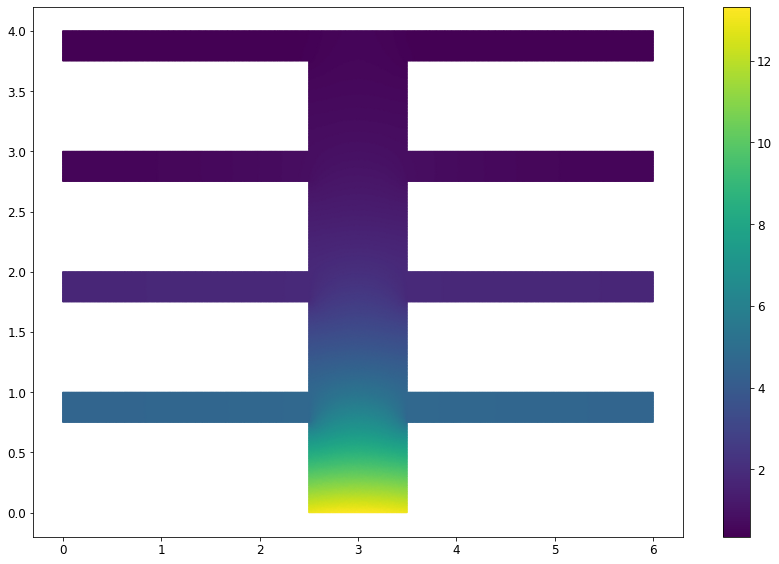

In [22]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

In [23]:
u = opt_fom.solve(mu_opt)
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    empty_bi = EmptyBoundaryInfo(data['grid'])
    u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
    diff= u.to_numpy()-u_d.to_numpy()
    diff_= opt_fom.solution_space.from_numpy(diff)
    Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

## Plot results

### J error

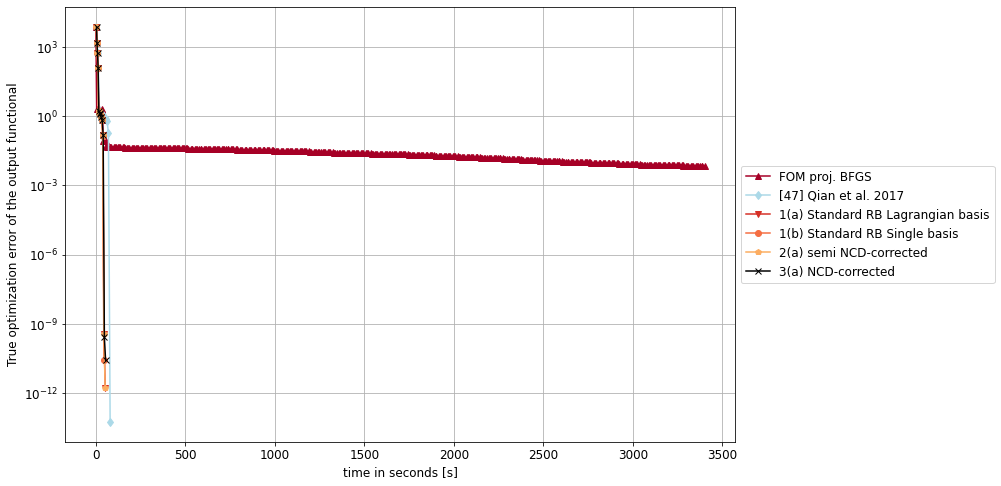

In [24]:
timings_figure = plt.figure()

color0 = (0.65,0,0.15)
color1 = (0.84,0.19,0.15)
color2 = (0.96,0.43,0.26)
color3 = (0.99,0.68,0.38)
color5 = (0.67,0.85,0.91)

#FOM
plt.semilogy(times_full_2,J_error_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,J_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,J_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,J_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,J_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,J_error_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot FOC

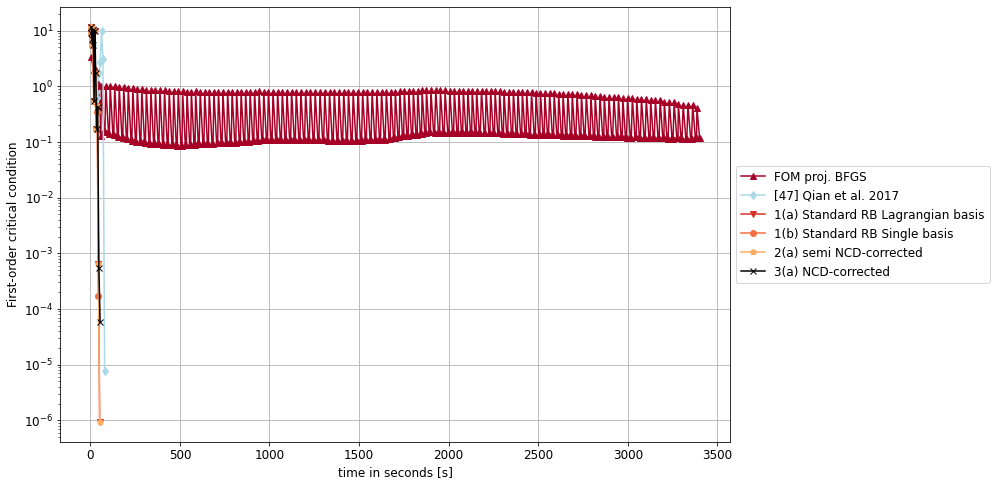

In [25]:
timings_figure = plt.figure()

#FOM
plt.semilogy(times_full_2[1:],FOC_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,FOC_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,FOC_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,FOC_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,FOC_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,FOC_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot Mu error

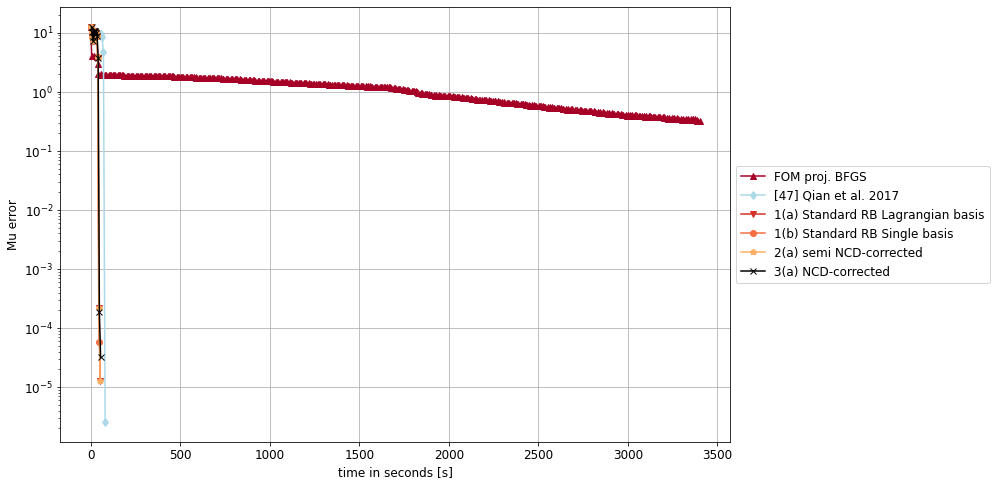

In [26]:
if mu_opt is not None:
    timings_figure = plt.figure()
    
    #FOM
    plt.semilogy(times_full_2,mu_error_2,'^-', color=color0, label='FOM proj. BFGS')

    # Qian et al. 2017
    plt.semilogy(times_full_26_actual,mu_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

    # Lagrange Basis
    plt.semilogy(times_full_25_actual,mu_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

    # Unique Basis
    plt.semilogy(times_full_54_actual,mu_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

    # Lagrange Basis
    plt.semilogy(times_full_39_actual,mu_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
    plt.semilogy(times_full_23_actual,mu_error_23_actual,'x-k', label='3(a) NCD-corrected')

    plt.xlabel('time in seconds [s]')
    plt.ylabel('Mu error')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the data

In [27]:
#save data
from pdeopt.tools import save_data
directory = './results/Starter7822'
save_data(directory, times_full_2, J_error_2, 2, mu_error=mu_error_2, FOC=FOC_2)
save_data(directory, times_full_23_actual, J_error_23_actual, 23, mu_error=mu_error_23_actual, FOC=FOC_23_actual)
save_data(directory, times_full_25_actual, J_error_25_actual, 25, mu_error=mu_error_25_actual, FOC=FOC_25_actual)
save_data(directory, times_full_26_actual, J_error_26_actual, 26, mu_error=mu_error_26_actual, FOC=FOC_26_actual)
save_data(directory, times_full_39_actual, J_error_39_actual, 39, mu_error=mu_error_39_actual, FOC=FOC_39_actual)
save_data(directory, times_full_54_actual, J_error_54_actual, 54, mu_error=mu_error_54_actual, FOC=FOC_54_actual)